In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import datetime
#import statsmodels.api as sm
sns.set()
%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

In [2]:
news = pd.read_csv('./Dataset/News_Final.csv',parse_dates=['PublishDate'])
# fe = pd.read_csv('./Dataset/Facebook_Economy.csv')

In [3]:
news.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus',
       'LinkedIn'],
      dtype='object')

In [5]:
year_distribute = news.PublishDate.apply(lambda x : x.year)
year_distribute.value_counts()

2016    72662
2015    20574
2012        1
2008        1
2002        1
Name: PublishDate, dtype: int64

### Problem1 : Is there any difference among the three platforms?
1. Check the variance: first make sure that the popularity varies in three groups.  <font color='red'>--- TASK: Diff plot/QQ plot</font>
2. Pick those news with huge difference, check what happened to those news.  <font color='red'>--- TASK: Pick the news with largest variance, check their sources, times, etc. Conclude what happened on these news. </font>
3. Check the variables: group by time; sources; sentiment; etc. 
4. Check the time series: <font color='red'>--- TASK: select difference time slice, and draw QQ plot. </font>

### Problem2 : Can we predict the popularity using the given variables? 
1. Theory: Time Series prediction: How do people predict popularity?     <font color='red'>--- TASK: read papers and blogs</font>
2. Check the variance inside each topic group: for example, if we use economy as dataset. Is there any relationship between the content/sentiment and their popularity? 

### Data Sanity Check: How many data can we actually use


1. Removed the news published on less than 3 platforms.

2. Checked the news with 0 popularity. Why? We need to calculate difference among platforms, if there are lots of news with 0 popularity, then the difference might not be real. -- Side Note: sources influence popularity. If it is completely the sources that influence the popularity rather than the platform, then we need to remove these items before intepreting the pop diff results. But we need to take sources back into consideration when building prediction model. 

#### How many news are on all three platforms?  Two platforms?  


In [6]:
print(f'Total news:{len(news)}\n')
F = news[news['Facebook']>0].Facebook
L = news[news['LinkedIn']>0].LinkedIn
G = news[news['GooglePlus']>0].GooglePlus
print(f'News on Facebook: {len(F)}')
print(f'News on LinkedIn: {len(L)}')
print(f'News on GooglePlus: {len(G)}\n')

news['num_platform'] = news["Facebook"].map(str) + ',' + news["GooglePlus"].map(str)+  ',' + news['LinkedIn'].map(str)
news['num_platform'] = news['num_platform'].apply(lambda x: [int(num) for num in x.split(',')])
news['num_platforms'] = news['num_platform'].apply(lambda x: 3 - x.count(-1)-x.count(0))
print(pd.DataFrame(news['num_platforms'].value_counts()).sort_index(ascending = False))

print('\nLet\'s drop the news with 0/1/2 platform!')

Total news:93239

News on Facebook: 64793
News on LinkedIn: 37640
News on GooglePlus: 36940

   num_platforms
3          23328
2          22608
1          24173
0          23130

Let's drop the news with 0/1/2 platform!


In [7]:
news_df = news[news['num_platforms']==3]

In [8]:
year_distribute = news_df.PublishDate.apply(lambda x : x.year)
year_distribute.value_counts()

2016    18059
2015     5269
Name: PublishDate, dtype: int64

#### Side: Where do the news come from?
1. 750/1732 sources have only 1 piece of news published.
2. 1300/1732 sources have only less than 6 news published.

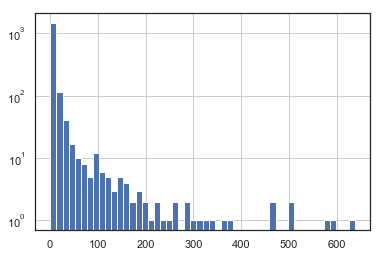

In [30]:
news_df.Source.value_counts().hist(bins = 50)
plt.yscale('log')

In [31]:
news_df.Source.value_counts()[:5]

The Guardian      637
Bloomberg         597
New York Times    582
Reuters           509
Forbes            501
Name: Source, dtype: int64

### How many news in each category?

In [32]:
len(news_df)
news_df.Topic.value_counts()

obama        8419
economy      7089
microsoft    7084
palestine     736
Name: Topic, dtype: int64

### Normalize the popularity

In [33]:
scaler = StandardScaler()
news_df['Facebook_scaled'] = scaler.fit_transform(news_df['Facebook'].values.reshape(-1, 1))
news_df['GooglePlus_scaled'] = scaler.fit_transform(news_df['GooglePlus'].values.reshape(-1, 1))
news_df['LinkedIn_scaled'] = scaler.fit_transform(news_df['LinkedIn'].values.reshape(-1, 1))

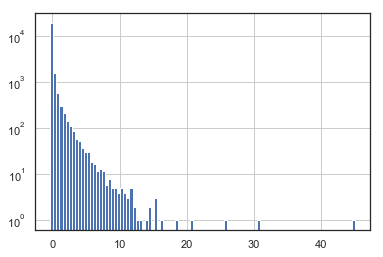

In [34]:
news_df['LinkedIn_scaled'].hist(bins=100)
plt.yscale('log')

In [36]:
news_df.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus',
       'LinkedIn', 'num_platform', 'num_platforms', 'Facebook_scaled',
       'GooglePlus_scaled', 'LinkedIn_scaled'],
      dtype='object')

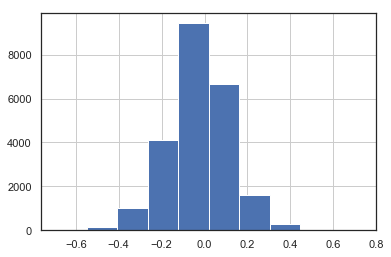

In [39]:
news_df.SentimentHeadline.hist()

In [23]:
news_df['num_platform_scaled'] = news_df["Facebook_scaled"].map(str) + ',' + news_df["GooglePlus_scaled"].map(str)+  ',' + news_df['LinkedIn_scaled'].map(str)
news_df['num_platform_scaled'] = news_df['num_platform_scaled'].apply(lambda x: [float(num) for num in x.split(',')])

### Is there any variance of same news on three platforms?  If there is, by how much? 
Two plots suggested by Bill 
1. Max - Min 
2. QQ plot

(-0.05, 1.05)

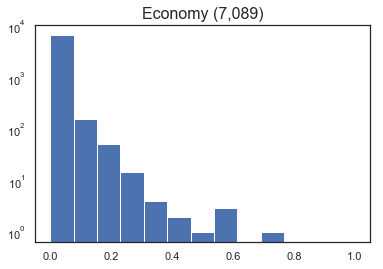

In [513]:
plt.hist(diff_micro,bins =10)
plt.yscale('log')
plt.title('Economy (7,089)', fontsize = 16)
plt.xlim(-0.05,1.05)

In [514]:
diff_micro.sort_values()[:500]

60798    0.000000
31231    0.000000
16754    0.000000
42492    0.000000
67425    0.000000
           ...   
64052    0.000314
52366    0.000314
28530    0.000314
11621    0.000314
71508    0.000314
Name: num_platform_scaled, Length: 500, dtype: float64

(-0.05, 1.05)

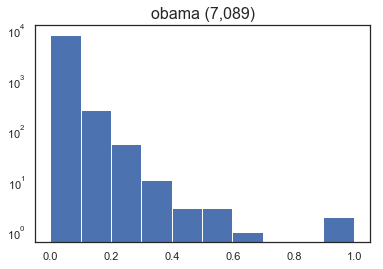

In [515]:
plt.hist(diff_obama,bins =10)
plt.yscale('log')
plt.title('obama (7,089)', fontsize = 16)
plt.xlim(-0.05,1.05)

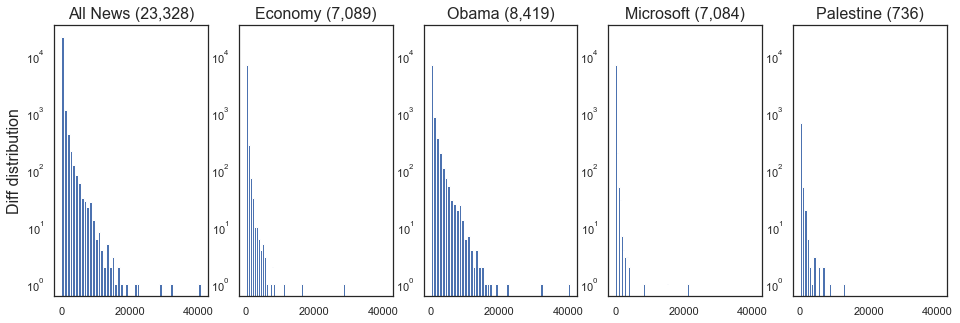

In [9]:
news_df['diff_among_groups'] = news_df['num_platform'].apply(lambda x: max(x)-min(x))
diff_among_groups = news_df['num_platform'].apply(lambda x: max(x)-min(x))
diff_econ = news_df[news_df['Topic']=='economy']['num_platform'].apply(lambda x: max(x)-min(x))
diff_obama = news_df[news_df['Topic']=='obama']['num_platform'].apply(lambda x: max(x)-min(x))
diff_micro = news_df[news_df['Topic']=='microsoft']['num_platform'].apply(lambda x: max(x)-min(x))
diff_pale = news_df[news_df['Topic']=='palestine']['num_platform'].apply(lambda x: max(x)-min(x))


plt.figure(figsize = (16,5))
ax1 = plt.subplot(1,5,1)
plt.hist(diff_among_groups,bins =50)
plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('All News (23,328)', fontsize = 16)

ax2 = plt.subplot(1,5,2,sharey = ax1, sharex = ax1)
plt.hist(diff_econ,bins =50)
plt.yscale('log')
plt.title('Economy (7,089)', fontsize = 16)

ax5 = plt.subplot(1,5,3, sharey = ax1, sharex = ax1)
plt.hist(diff_obama,bins =50)
plt.yscale('log')
plt.title('Obama (8,419)', fontsize = 16);

ax3 = plt.subplot(1,5,4, sharey = ax1,sharex = ax1)
plt.hist(diff_micro,bins =50)
plt.yscale('log')
plt.title('Microsoft (7,084)', fontsize = 16)

ax4 = plt.subplot(1,5,5, sharey = ax1,sharex = ax1)
plt.hist(diff_pale,bins =20)
plt.yscale('log')
plt.title('Palestine (736)', fontsize = 16);

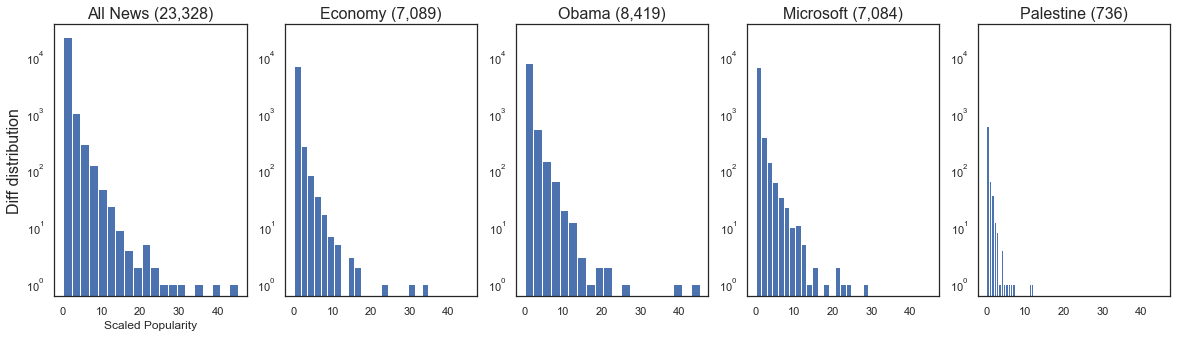

In [55]:
news_df['diff_among_groups'] = news_df['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_among_groups = news_df['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_econ = news_df[news_df['Topic']=='economy']['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_obama = news_df[news_df['Topic']=='obama']['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_micro = news_df[news_df['Topic']=='microsoft']['num_platform_scaled'].apply(lambda x: max(x)-min(x))
diff_pale = news_df[news_df['Topic']=='palestine']['num_platform_scaled'].apply(lambda x: max(x)-min(x))


plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,5,1)
plt.hist(diff_among_groups,bins =20)
plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.xlabel('Scaled Popularity')
plt.title('All News (23,328)', fontsize = 16)

ax2 = plt.subplot(1,5,2,sharex = ax1, sharey = ax1)
plt.hist(diff_econ,bins =20)
plt.yscale('log')
plt.title('Economy (7,089)', fontsize = 16)

ax5 = plt.subplot(1,5,3, sharex = ax1,sharey = ax1)
plt.hist(diff_obama,bins =20)
plt.yscale('log')
plt.title('Obama (8,419)', fontsize = 16);

ax3 = plt.subplot(1,5,4, sharex = ax1,sharey = ax1)
plt.hist(diff_micro,bins =20)
plt.yscale('log')
plt.title('Microsoft (7,084)', fontsize = 16)

ax4 = plt.subplot(1,5,5, sharex = ax1, sharey = ax1)
plt.hist(diff_pale,bins =20)
plt.yscale('log')
plt.title('Palestine (736)', fontsize = 16);

In [210]:
news_df.loc[85833].Title

"Israel 'cuts water supply' to West Bank during Ramadan"

In [211]:
news_df.loc[85833]

IDLink                                                            101578
Title                  Israel 'cuts water supply' to West Bank during...
Headline               Mekorot, the main supplier of water to Palesti...
Source                                                     Aljazeera.com
Topic                                                          palestine
PublishDate                                          2016-06-16 11:35:51
SentimentTitle                                                  0.145833
SentimentHeadline                                             -0.0384946
Facebook                                                           13146
GooglePlus                                                           214
LinkedIn                                                              53
num_platform                                            [13146, 214, 53]
num_platforms                                                          3
Facebook_scaled                                    

In [209]:
diff_pale.sort_values(ascending = False)

85833    12.136141
41520    11.484571
89233     7.120440
7689      6.299612
50000     5.585900
           ...    
73342     0.010325
7655      0.010325
80641     0.008870
70318     0.005668
90032     0.005668
Name: num_platform_scaled, Length: 736, dtype: float64

In [56]:
all_log = np.log(diff_among_groups)
eco_log = np.log(diff_econ)
obama_log = np.log(diff_obama)
micro_log = np.log(diff_micro)
pale_log = np.log(diff_pale)

In [83]:
all_log.mean()

-1.6227664417759362

In [77]:
obama_log.mean()

-1.2322405366437295

In [78]:
eco_log.mean()

-1.8982720705909777

In [79]:
micro_log.mean()

-1.794575242390058

In [80]:
pale_log.mean()

-1.7826640628195884

In [86]:
from scipy import stats
t,p = stats.ttest_ind(all_log,micro_log)
p

1.3974980466606818e-17

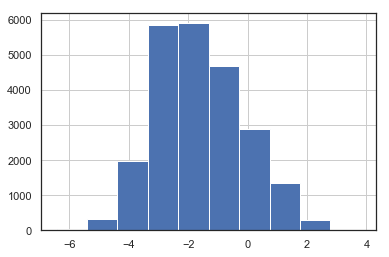

In [213]:
all_log.hist()


Text(0.5, 1.0, 'Log(Diff) of the Four Categories')

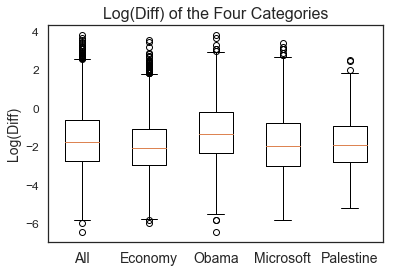

In [220]:
plt.boxplot([all_log, eco_log, obama_log,micro_log,pale_log]);
plt.xticks([1,2,3,4,5],['All', 'Economy', 'Obama','Microsoft','Palestine'], fontsize = 14);
plt.yticks(fontsize = 12)
plt.ylabel('Log(Diff)',fontsize = 14)
plt.title('Log(Diff) of the Four Categories',fontsize =16)

Text(0.5, 1.0, 'Reuters(509)')

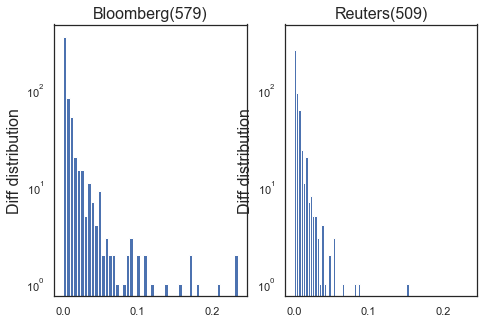

In [478]:
bloom_news = news_df[news_df['Source']=='Bloomberg']
reuter_new = news_df[news_df['Source']=='Reuters']

plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,5,1)
plt.hist(bloom_news.diff_among_groups,bins =50)
plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('Bloomberg(579)', fontsize = 16)

ax2 = plt.subplot(1,5,2, sharex = ax1, sharey = ax1)
plt.hist(reuter_new.diff_among_groups,bins =50)
plt.yscale('log')
plt.ylabel('Diff distribution', fontsize = 16)
plt.title('Reuters(509)', fontsize = 16)


### Aggragated topics

In [154]:
f_pop = np.log(news_df['Facebook_scaled'])
l_pop = np.log(news_df['LinkedIn_scaled'])
g_pop = np.log(news_df['GooglePlus_scaled'])
'''
f_pop = news_df['Facebook']
l_pop = news_df['LinkedIn']
g_pop = news_df['GooglePlus']
'''

"\nf_pop = news_df['Facebook']\nl_pop = news_df['LinkedIn']\ng_pop = news_df['GooglePlus']\n"

In [160]:
f_pop = news_df['Facebook_scaled']
l_pop = news_df['LinkedIn_scaled']
g_pop = news_df['GooglePlus_scaled']

Text(0, 0.5, 'Facebook')

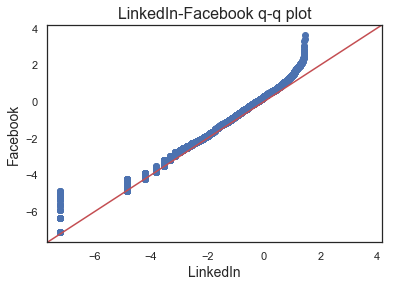

In [155]:
pp_f = sm.ProbPlot(f_pop, fit=False)
pp_l = sm.ProbPlot(l_pop, fit=False)
pp_g = sm.ProbPlot(g_pop, fit=False)

fig1 = pp_f.qqplot(other=pp_l, line='45')
plt.title('LinkedIn-Facebook q-q plot', fontsize = 16)
plt.xlabel('LinkedIn', fontsize = 14)
plt.ylabel('Facebook',fontsize = 14)

Text(0, 0.5, 'GooglePlus')

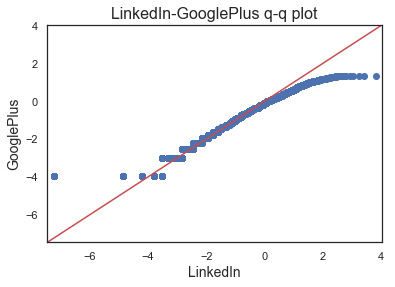

In [156]:
fig2 = pp_g.qqplot(other=pp_l, line='45')
plt.title('LinkedIn-GooglePlus q-q plot', fontsize = 16)

plt.xlabel('LinkedIn', fontsize = 14)
plt.ylabel('GooglePlus', fontsize = 14)

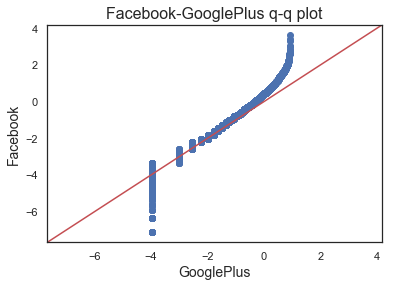

In [157]:

fig3 = pp_f.qqplot(other=pp_g, line='45')
plt.title('Facebook-GooglePlus q-q plot', fontsize = 16)

plt.ylabel('Facebook', fontsize = 14)
plt.xlabel('GooglePlus', fontsize = 14);

#### We need to filter out those news with higher popularity and see what happens. 

Text(0.5, 1.0, 'Normalized popularity over all the news')

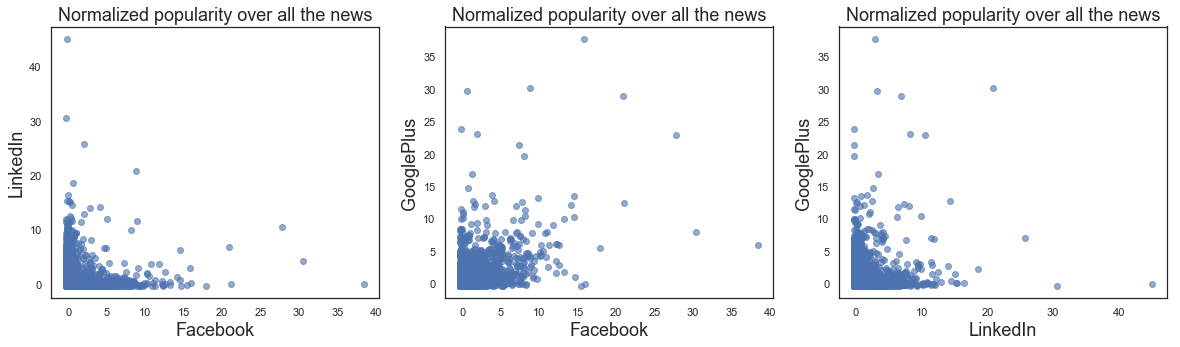

In [170]:
plt.figure(figsize = (20,5))

ax1 = plt.subplot(1,3,1)
ax1 = plt.scatter(f_pop, l_pop,alpha = 0.6)
plt.xlabel('Facebook', fontsize = 18)
plt.ylabel('LinkedIn', fontsize = 18)
plt.title('Normalized popularity over all the news',fontsize = 18)

ax2 = plt.subplot(1,3,2)
ax2 = plt.scatter(f_pop, g_pop,alpha = 0.6)
plt.xlabel('Facebook', fontsize = 18)
plt.ylabel('GooglePlus', fontsize = 18)
plt.title('Normalized popularity over all the news',fontsize = 18)


ax3 = plt.subplot(1,3,3)
ax3 = plt.scatter(l_pop, g_pop,alpha = 0.6)
plt.xlabel('LinkedIn', fontsize = 18)
plt.ylabel('GooglePlus', fontsize = 18)
plt.title('Normalized popularity over all the news',fontsize = 18)


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text xticklabel objects>)

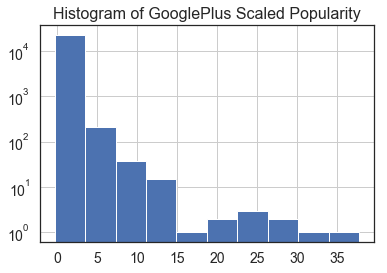

In [189]:
news_df['GooglePlus_scaled'].hist()
plt.yscale('log')
plt.title('Histogram of GooglePlus Scaled Popularity', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

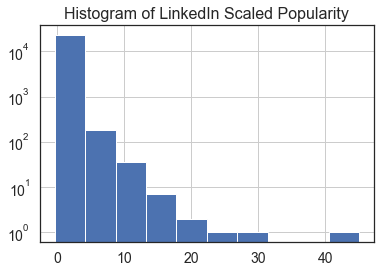

In [191]:
news_df['LinkedIn_scaled'].hist()
plt.yscale('log')
plt.title('Histogram of LinkedIn Scaled Popularity', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 11 Text xticklabel objects>)

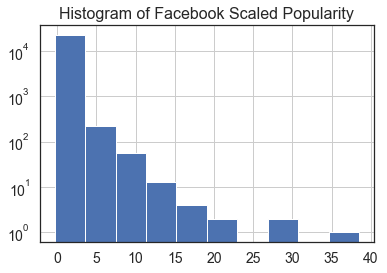

In [192]:
news_df['Facebook_scaled'].hist()
plt.yscale('log')
plt.title('Histogram of Facebook Scaled Popularity', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

Text(0.5, 1.0, 'Normalized popularity (microsoft)')

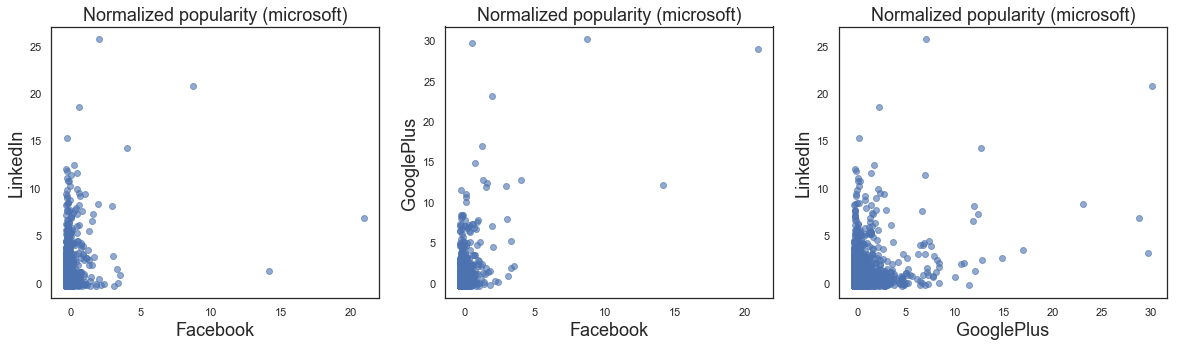

In [175]:
topics = ['obama', 'microsoft','economy', 'palestine']
topic = topics[1]

f_e_pop = news_df[news_df['Topic']==topic].Facebook_scaled
l_e_pop = news_df[news_df['Topic']==topic].LinkedIn_scaled
g_e_pop = news_df[news_df['Topic']==topic].GooglePlus_scaled

plt.figure(figsize = (20,5))

ax1 = plt.subplot(1,3,1)
ax1 = plt.scatter(f_e_pop, l_e_pop,alpha = 0.6)
plt.xlabel('Facebook',fontsize = 18)
plt.ylabel('LinkedIn',fontsize = 18)
plt.title('Normalized popularity (%s)'%topic,fontsize = 18)


ax2 = plt.subplot(1,3,2)
ax2 = plt.scatter(f_e_pop, g_e_pop,alpha = 0.6)
plt.xlabel('Facebook',fontsize = 18)
plt.ylabel('GooglePlus',fontsize = 18)
plt.title('Normalized popularity (%s)'%topic,fontsize = 18)


ax3 = plt.subplot(1,3,3)
ax3 = plt.scatter(g_e_pop,l_e_pop,alpha = 0.6)
plt.xlabel('GooglePlus',fontsize = 18)
plt.ylabel('LinkedIn',fontsize = 18)
plt.title('Normalized popularity (%s)'%topic,fontsize = 18)

Text(0, 0.5, 'GooglePlus')

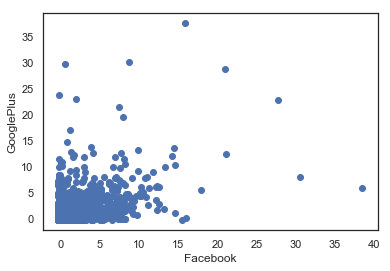

In [525]:
plt.scatter(f_pop, g_pop)
plt.xlabel('Facebook')
plt.ylabel('GooglePlus')

### Different Topics

In [521]:
topics = ['obama', 'microsoft','economy', 'palestine']
topic = topics[1]

f_e_pop = news_df[news_df['Topic']==topic].Facebook_scaled
l_e_pop = news_df[news_df['Topic']==topic].LinkedIn_scaled
g_e_pop = news_df[news_df['Topic']==topic].GooglePlus_scaled

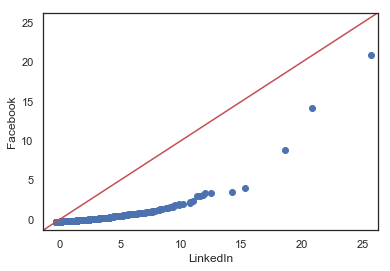

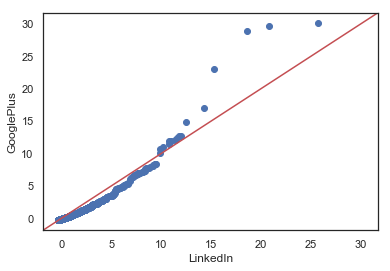

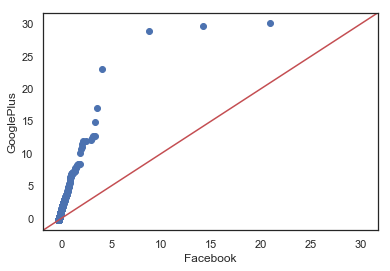

In [221]:
pp_f = sm.ProbPlot(f_e_pop, fit=False)
pp_l = sm.ProbPlot(l_e_pop, fit=False)
pp_g = sm.ProbPlot(g_e_pop, fit=False)

fig1 = pp_f.qqplot(other=pp_l, line='45')
plt.xlabel('LinkedIn')
plt.ylabel('Facebook')

fig2 = pp_g.qqplot(other=pp_l, line='45')
plt.xlabel('LinkedIn')
plt.ylabel('GooglePlus')

fig3 = pp_g.qqplot(other=pp_f, line='45')
plt.xlabel('Facebook')
plt.ylabel('GooglePlus');

In [486]:
obama_news = news_df[news_df['Topic']=='obama']

In [402]:
obama_news.corr()

,IDLink,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Title_len,num_platforms,diff_among_groups,Facebook_scaled,GooglePlus_scaled,LinkedIn_scaled,all_zero
IDLink,1.000000,0.010192,0.026348,-0.090157,-0.100104,0.023882,0.009895,NaN,-0.106604,-0.090157,-0.100104,0.023882,-0.000182
SentimentTitle,0.010192,1.000000,0.193300,-0.009552,-0.015315,0.008562,0.011494,NaN,-0.011885,-0.009552,-0.015315,0.008562,0.018258
SentimentHeadline,0.026348,0.193300,1.000000,-0.017029,-0.012199,0.006574,0.007208,NaN,-0.016813,-0.017029,-0.012199,0.006574,0.003537
Facebook,-0.090157,-0.009552,-0.017029,1.000000,0.601368,0.175585,0.035356,NaN,0.847081,1.000000,0.601368,0.175585,-0.106428
GooglePlus,-0.100104,-0.015315,-0.012199,0.601368,1.000000,0.161106,0.059692,NaN,0.780565,0.601368,1.000000,0.161106,-0.110673
LinkedIn,0.023882,0.008562,0.006574,0.175585,0.161106,1.000000,0.005003,NaN,0.424282,0.175585,0.161106,1.000000,-0.050085
Title_len,0.009895,0.011494,0.007208,0.035356,0.059692,0.005003,1.000000,NaN,0.050899,0.035356,0.059692,0.005003,-0.066479
num_platforms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diff_among_groups,-0.106604,-0.011885,-0.016813,0.847081,0.780565,0.424282,0.050899,NaN,1.000000,0.847081,0.780565,0.424282,-0.121095
Facebook_scaled,-0.090157,-0.009552,-0.017029,1.000000,0.601368,0.175585,0.035356,NaN,0.847081,1.000000,0.601368,0.175585,-0.106428


In [404]:
news_df[['diff_among_groups', 'SentimentTitle']][:5]

,diff_among_groups,SentimentTitle
736,0.002665,-0.055902
738,0.000245,-0.018326
742,0.000716,0.004360
746,0.007699,0.037689
747,0.001408,-0.166667


In [54]:
news_df['Source'].value_counts()

The Guardian                 637
Bloomberg                    597
New York Times               582
Reuters                      509
Forbes                       501
                            ... 
Buenos Aires Herald            1
Medical Daily                  1
Triangle Business Journal      1
PennLive.com                   1
West Virginia MetroNews        1
Name: Source, Length: 1732, dtype: int64

In [135]:
source_sentiment_check_df = news_df[news_df['Source']=='New York Times']

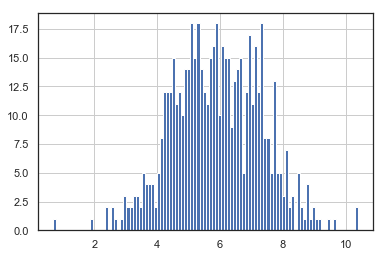

In [136]:
np.log(source_sentiment_check_df.Facebook).hist(bins = 100)

In [137]:
X = np.log(source_sentiment_check_df.Facebook)
Y = source_sentiment_check_df.SentimentTitle
Z = source_sentiment_check_df.SentimentHeadline

In [138]:
senticheck_df = pd.DataFrame(data = {'facebook_pop':X,'sent_title':Y, 'sent_head':Z})

In [139]:
senticheck_df.corr()

,facebook_pop,sent_title,sent_head
facebook_pop,1.000000,0.053025,0.105289
sent_title,0.053025,1.000000,0.187483
sent_head,0.105289,0.187483,1.000000


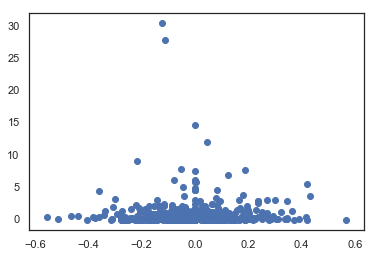

In [140]:
plt.scatter(Y, source_sentiment_check_df.Facebook_scaled)

In [148]:
neg = senticheck_df[senticheck_df['sent_head']<0]
pos = senticheck_df[senticheck_df['sent_head']>0]

In [149]:
pos.corr()

,facebook_pop,sent_title,sent_head
facebook_pop,1.000000,0.053065,0.093694
sent_title,0.053065,1.000000,0.107866
sent_head,0.093694,0.107866,1.000000


In [150]:
neg.corr()

,facebook_pop,sent_title,sent_head
facebook_pop,1.000000,0.031256,0.067746
sent_title,0.031256,1.000000,0.100537
sent_head,0.067746,0.100537,1.000000


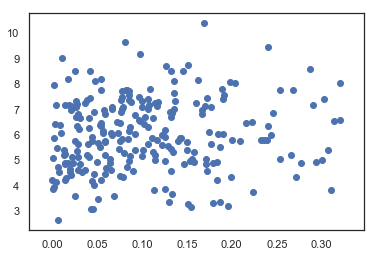

In [151]:
plt.scatter(pos.sent_head, pos.facebook_pop)

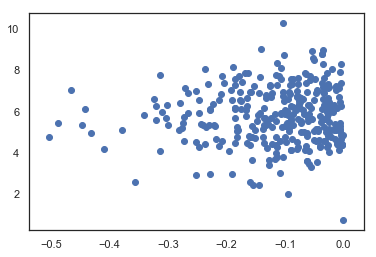

In [152]:
plt.scatter(neg.sent_head, neg.facebook_pop)

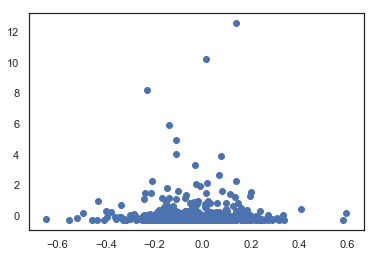

In [92]:
plt.scatter(Z,source_sentiment_check_df.Facebook_scaled)

In [163]:
news_df.set_index('Title').loc['Fact Check: Top 10 Lies in Obama\'s State of the Union']

IDLink                                                           72143
Headline             President Barack Obama promised his final Stat...
Source                                                  Breitbart News
Topic                                                            obama
PublishDate                                        2016-01-13 05:44:47
SentimentTitle                                                0.118585
SentimentHeadline                                              -0.1445
Facebook                                                         40836
GooglePlus                                                         210
LinkedIn                                                            42
num_platform                                          [40836, 210, 42]
num_platforms                                                        3
Facebook_scaled                                                38.5116
GooglePlus_scaled                                              5.94192
Linked

In [178]:
news_df.set_index('Title').loc['Michele Bachmann warns Obama will take over the United Nations ...']

IDLink                                                           75688
Headline             Bachmann then cited a dubiously sourced report...
Source                                                       Raw Story
Topic                                                            obama
PublishDate                                        2016-02-02 13:13:30
SentimentTitle                                              -0.0368932
SentimentHeadline                                           -0.0340529
Facebook                                                          8120
GooglePlus                                                         725
LinkedIn                                                             8
num_platform                                            [8120, 725, 8]
num_platforms                                                        3
Facebook_scaled                                                7.40862
GooglePlus_scaled                                              21.4259
Linked

In [196]:
fo = pd.read_csv('./Dataset/Facebook_Obama.csv')

In [198]:
fo.IDLink = fo.IDLink.apply(lambda x: int(x))

In [199]:
time_series = fo.set_index('IDLink').loc[72143]

In [200]:
time_x = time_series.index.to_list()

In [179]:
miss_obama = fo.set_index('IDLink').loc[76901]
obama_take_over = fo.set_index('IDLink').loc[75688]

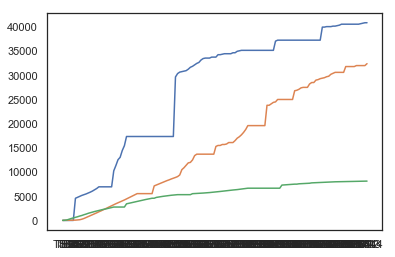

In [180]:
plt.plot(time_x, time_series.values)
plt.plot(time_x, miss_obama.values)
plt.plot(time_x, obama_take_over.values)


In [194]:
fo.set_index('IDLink')

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,...,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
IDLink,,,,,,,,,,,,,,,,,,,,,
61874,-1,-1,-1,-1,-1,-1,-1,-1,-1,394,...,748,748,748,748,748,748,748,748,748,748
61875,-1,-1,-1,-1,-1,-1,-1,-1,-1,157,...,546,546,546,546,546,546,546,546,546,546
61876,-1,-1,-1,-1,-1,-1,44,45,48,51,...,140,140,140,140,140,140,140,140,140,140
61877,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,176,176,176,176,176,176,176,176,176,176
61878,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,206,206,206,206,206,206,206,206,206,206
61879,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,205,205,205,205,205,205,205,205,205,205
61880,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1020,1020,1020,1021,1023,1023,1023,1023,1023,1023
61881,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,179,179,179,179,179,179,179,179,179,179
61882,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,609,609,609,609,609,609,609,609,609,609


In [237]:
top_obama_f = news_df[news_df['Topic']=='obama'][['IDLink','Facebook']].sort_values(by = 'Facebook',ascending = False)[:50]
top_obama_f[:5]

,IDLink,Facebook
25813,72143.0,40836
37050,76901.0,32385
15329,67508.0,22518
10454,65424.0,19136
14657,67141.0,17170


In [214]:
import plotly.offline as py
py.init_notebook_mode(connected=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


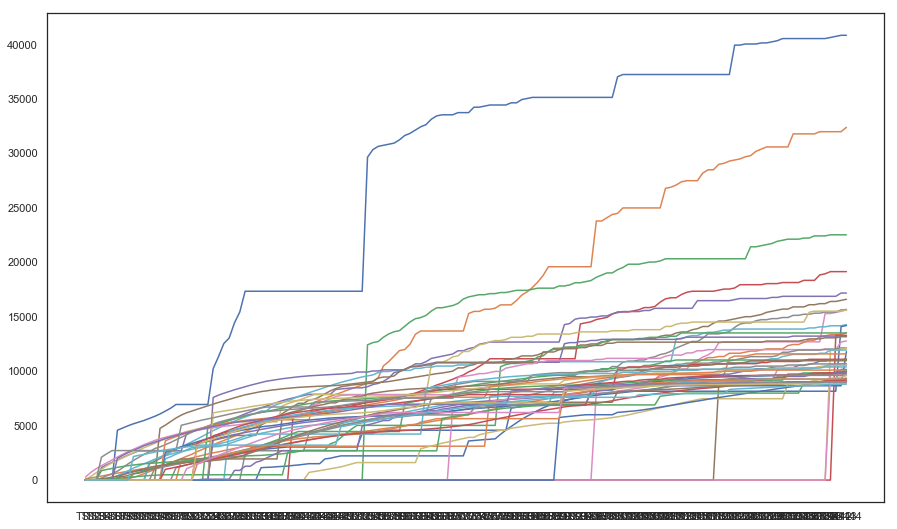

In [239]:
plt.figure(figsize = (15,9))
for i in range(50):
    idx = top_obama_f.iloc[i][0]
    ts = fo.set_index('IDLink').loc[idx].values
    plt.plot(time_x, ts, label = idx)
# plt.legend()

In [233]:
lo = pd.read_csv('./Dataset/LinkedIn_Obama.csv')
top_obama_l = news_df[news_df['Topic']=='obama'][['IDLink','LinkedIn']].sort_values(by = 'LinkedIn',ascending = False)[:50]
top_obama_l[:5]

,IDLink,LinkedIn
87245,102171.0,6362
32694,74997.0,1858
91658,104089.0,1665
27251,72807.0,1648
33302,75291.0,1483


In [234]:
news_df.set_index('IDLink').loc[102171]

Title                Obama on post-White House job plans: 'I'm gonn...
Headline             President Barack Obama endorsed LinkedIn as a ...
Source                                                        Politico
Topic                                                            obama
PublishDate                                        2016-06-20 18:40:11
SentimentTitle                                               0.0578854
SentimentHeadline                                            -0.133436
Facebook                                                           161
GooglePlus                                                          10
LinkedIn                                                          6362
num_platform                                           [161, 10, 6362]
num_platforms                                                        3
Facebook_scaled                                              -0.157967
GooglePlus_scaled                                           -0.0712714
Linked

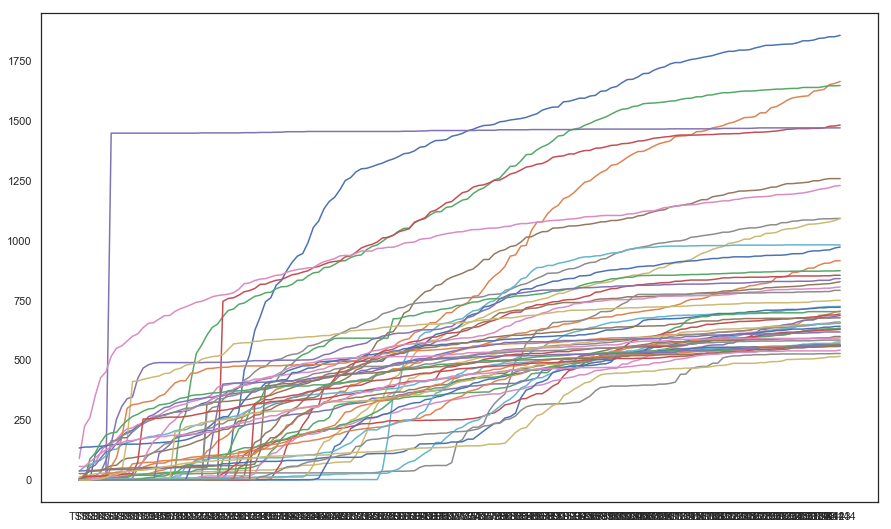

In [236]:
plt.figure(figsize = (15,9))
for i in range(1,50):
    idx = top_obama_l.iloc[i][0]
    ts_l = lo.set_index('IDLink').loc[idx].values
    plt.plot(time_x, ts_l, label = idx)
#plt.legend()